This notebook is a summary of the ETL process for the project. The data has been crawled and stored in MongoDB. The ETL process starts by reading the data from MongoDB and storing it in HDFS. We process and transform the data through three layers: Bronze, Silver, and Gold. Afterwards, we perform EDA (Exploratory Data Analysis) and use the data to build a Spotify Recommendation System model.

For more details, please visit our repo: [**Spotify Analysis with PySpark**](https://github.com/PhongHuynh0394/Spotify-Analysis-with-PySpark).

Link: https://github.com/PhongHuynh0394/Spotify-Analysis-with-PySpark

# ETL (Extract, Transform, Load)

## Import Module

In [130]:
import os
import pyspark
import seaborn as sns
import pandas as pd
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql.functions import collect_list, col, concat_ws, substring
from pyspark.sql.functions import col, split, monotonically_increasing_id
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import DataFrame
from pyarrow import flight
from datetime import datetime
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

## IO Managaer

### Spark IO

In [131]:
from contextlib import contextmanager

@contextmanager
def SparkIO(conf: SparkConf = SparkConf()):
    app_name = conf.get("spark.app.name")
    master = conf.get("spark.master")
    print(f'Create SparkSession app {app_name} with {master} mode')
    spark = SparkSession.builder.config(conf=conf).getOrCreate()
    try:
        yield spark
    except Exception:
        raise Exception
    finally:
        print(f'Stop SparkSession app {app_name}')
        spark.stop()

### MongoDB IO

In [132]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure
from contextlib import contextmanager
import os

@contextmanager
def MongodbIO():
    user = os.getenv("MONGODB_USER")
    password = os.getenv("MONGODB_PASSWORD")
    cluster = os.getenv("MONGODB_SRV")
    cluster = cluster.split("//")[-1]
    uri = f"mongodb+srv://{user}:{password}@{cluster}/?retryWrites=true&w=majority"
    try:
        client = MongoClient(uri)
        print(f"MongoDB Connected")
        yield client
    except ConnectionFailure:
        print(f"Failed to connect with MongoDB")
        raise ConnectionFailure
    finally:
        print("Close connection to MongoDB")
        client.close()

## Bronze layer
In this layer, we'll fully load all raw data from MongoDB to HDFS and store it as a Parquet file. However, before proceeding with this, we'll establish the data schema for the Spark DataFrame instead of relying on the dynamic schema of the PySpark DataFrame. This precautionary step will help us avoid errors related to schema or data types when writing data to Parquet or loading data from MongoDB Atlas.

In [133]:
def getSchema(table_name):
    """This function create Pyspark Schema"""
    artist_schema = StructType([
        StructField("_id", StringType(), True),
        StructField(
            "external_urls",
            StructType([
                StructField("spotify", StringType(), True)
            ])
        ),
        StructField(
            "followers", 
            StructType([
                StructField("href", StringType(), True),
                StructField("total", IntegerType(), True)
            ])
        ),
        StructField(
            "genres",
            ArrayType(StringType(), True)      
        ),
        StructField("href", StringType(), True),
        StructField("id", StringType(), True),
        StructField(
            "images",
            ArrayType(
                StructType([
                    StructField("height", IntegerType(), True),
                    StructField("url", StringType(), True),
                    StructField("width", IntegerType(), True)
                ])
            )
        ),
        StructField("name", StringType(), True),
        StructField("popularity", IntegerType(), True),
        StructField("type", StringType(), True),
        StructField("uri", StringType(), True)
    ])

    album_schema = StructType([
        StructField("_id", StringType(), True),
        StructField("album_type", StringType(), True),
        StructField(
            "copyrights",
            ArrayType(
                StructType([
                    StructField("text", StringType(), True),
                    StructField("type", StringType(), True)
                ])
            )
        ),
        StructField(
            "external_ids",
            StructType([
                StructField("upc", StringType(), True)
            ])
        ),
        StructField(
            "external_urls",
            StructType([
                StructField("spotify", StringType(), True)
            ])
        ),
        StructField(
            "genres",
            ArrayType(StringType(), True)
        ),
        StructField("href", StringType(), True),
        StructField("id", StringType(), True),
        StructField(
            "images",
            ArrayType(
                StructType([
                    StructField("height", IntegerType(), True),
                    StructField("url", StringType(), True),
                    StructField("width", IntegerType(), True)
                ])
            )
        ),
        StructField("label", StringType(), True),
        StructField("name", StringType(), True),
        StructField("popularity", IntegerType(), True),
        StructField("release_date", StringType(), True),
        StructField("release_date_precision", StringType(), True),
        StructField("total_tracks", IntegerType(), True),
        StructField("type", StringType(), True),
        StructField("uri", StringType(), True),
        StructField("artist_id", StringType(), True)
    ])

    track_schema = StructType([
        StructField("_id", StringType(), True),
        StructField("disc_number", IntegerType(), True),
        StructField("duration_ms", LongType(), True),
        StructField("explicit", BooleanType(), True),
        StructField(
            "external_ids",
            StructType([
                StructField("isrc", StringType(), True)
            ])
        ),
        StructField(
            "external_urls",
            StructType([
                StructField("spotify", StringType(), True)
            ])
        ),
        StructField("href", StringType(), True),
        StructField("id", StringType(), True),
        StructField("is_local", BooleanType(), True),
        StructField("name", StringType(), True),
        StructField("popularity", IntegerType(), True),
        StructField("preview_url", StringType(), True),
        StructField("track_number", IntegerType(), True),
        StructField("type", StringType(), True),
        StructField("uri", StringType(), True),
        StructField("artist_id", StringType(), True),
        StructField("album_id", StringType(), True)
    ])

    track_features_schema = StructType([
        StructField("_id", StringType(), True),
        StructField("danceability", DoubleType(), True),
        StructField("energy", DoubleType(), True),
        StructField("key", IntegerType(), True),
        StructField("loudness", DoubleType(), True),
        StructField("mode", IntegerType(), True),
        StructField("speechiness", DoubleType(), True),
        StructField("acousticness", DoubleType(), True),
        StructField("instrumentalness", DoubleType(), True),
        StructField("liveness", DoubleType(), True),
        StructField("valence", DoubleType(), True),
        StructField("tempo", DoubleType(), True),
        StructField("type", StringType(), True),
        StructField("id", StringType(), True),
        StructField("uri", StringType(), True),
        StructField("track_href", StringType(), True),
        StructField("analysis_url", StringType(), True),
        StructField("duration_ms", LongType(), True),
        StructField("time_signature", IntegerType(), True)
    ])
    if 'artist' in table_name:
        return artist_schema
    elif 'album' in table_name:
        return album_schema
    elif 'feature' in table_name:
        return track_features_schema
    else:
        return track_schema

In [134]:
def bronze_layer_task(spark: SparkSession, mongo_uri: str, database_name: str, table_name: str) -> None:
    """Extract data from MongoDB to HDFS at bronze layer"""

    hdfs_uri = f"hdfs://namenode:8020/bronze_layer/{table_name}.parquet"

    spark_data = (spark.read.format("mongodb")
              .schema(getSchema(table_name))
              .option("uri", mongo_uri)
              .option('database', database_name)
              .option('collection', table_name)
              .load()
              .select([col for col in getSchema(table_name).fieldNames() if col != '_id']) # eliminate _id field
              )

    print(f"Writing {table_name}")
    spark_data.write.parquet(hdfs_uri, mode="overwrite")
    print(f"Bronze: Successfully writing {table_name}.parquet")


def IngestHadoop(client, uri, spark: SparkSession):
    """Extract data From MongoDB and Load to HDFS"""

    database_name = os.getenv("MONGODB_DATABASE")
    mongo_db = client[database_name] 
    collections = mongo_db.list_collection_names() #get all collectons

    #Running task concurrently
    for collection in collections:
        print(f"{collection} start being Ingested...")
        bronze_layer_task(spark, uri, database_name, collection) #collection is also the name of table

## Silver layer
In this phase, we'll handle the transformation of each table individually. To carry out the transformation for the silver layer, let's create a dedicated Silver class for this task.

In [135]:
from pyspark.sql.functions import col, explode
import pyspark
from typing import Dict, List

In [136]:
def cleanList(self, columns: dict, drop: bool = False):
    # Check type of argument
    if not isinstance(columns, dict):
        raise TypeError("Columns must be a dictionary")
    if not isinstance(drop, bool):
        raise TypeError("Drop must be a boolean")

    df_exploded = self

    for old_column in columns.keys():
        new_column = columns[old_column]
        df_exploded = df_exploded.select(
            "*", explode(col(old_column)).alias(new_column))

    if drop:
        return df_exploded.drop(*columns.keys())
    return df_exploded

We have developed a custom method for the ```pyspark.sql.DataFrame``` class. This method addresses the issue in Pyspark Dataframe where a value is not a single unit value but a list value.

Perform data transforming in Silver layer:
- Process nested columns (optional)
- Process list values (optional)
- Split Dataframe to convert into 3NF-Normalization

In [137]:
hdfs_uri = f"hdfs://namenode:8020/bronze_layer/artists_data.parquet"
artists_data = spark.read.parquet(hdfs_uri, inferSchema=True, header=True)
artists_data.show(2, vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 external_urls | {https://open.spotify.com/artist/3TVXtAsR1Inumwj472S9r4}                                                                                                                                                                                   
 followers     | {null, 82834676}                                                                                                                                                                                                                           
 genres        | [canadian hip hop, canadian pop, hip hop, pop rap, rap]                                                                                                                                                                         

In [138]:
## Process nested columns
print(artists_data.select("external_urls").first())

Row(external_urls=Row(spotify='https://open.spotify.com/artist/3TVXtAsR1Inumwj472S9r4'))


In [139]:
artists_data.withColumn(colName="new_external_urls", col=col("external_urls.spotify")).show(1, vertical=True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 external_urls     | {https://open.spotify.com/artist/3TVXtAsR1Inumwj472S9r4}                                                                                                                                                                                   
 followers         | {null, 82834676}                                                                                                                                                                                                                           
 genres            | [canadian hip hop, canadian pop, hip hop, pop rap, rap]                                                                                                                                                         

It is observed that the URL, previously nested within the "external_urls" column, has been successfully extracted and relocated to a newly created column called "new_external_urls."

In [140]:
cleaned_nested_columns = artists_data.alias("artists_data")
nested_columns={"artist_url": col("external_urls.spotify"), 
                "artist_followers": col("followers.total"),
                "artist_image": col("images")[0].url}
for new_column, field_to_extract in nested_columns.items():
    cleaned_nested_columns = cleaned_nested_columns.withColumn(colName=new_column, col=field_to_extract)
cleaned_nested_columns.show(1, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 external_urls    | {https://open.spotify.com/artist/3TVXtAsR1Inumwj472S9r4}                                                                                                                                                                                   
 followers        | {null, 82834676}                                                                                                                                                                                                                           
 genres           | [canadian hip hop, canadian pop, hip hop, pop rap, rap]                                                                                                                                                             

In [141]:
## Process list values
cleaned_nested_columns.select(["id", "name", "genres"]).show(5)

+--------------------+------------+--------------------+
|                  id|        name|              genres|
+--------------------+------------+--------------------+
|3TVXtAsR1Inumwj47...|       Drake|[canadian hip hop...|
|4q3ewBCX7sLwd24eu...|   Bad Bunny|[reggaeton, trap ...|
|4q3ewBCX7sLwd24eu...|   Bad Bunny|[reggaeton, trap ...|
|06HL4z0CvFAxyc27G...|Taylor Swift|               [pop]|
|1Xyo4u8uXC1ZmMpat...|  The Weeknd|[canadian contemp...|
+--------------------+------------+--------------------+
only showing top 5 rows



Column ```genres``` contains values that are not a single unit value.

In [142]:
cleaned_list_values = cleaned_nested_columns.cleanList(columns={"genres": "genre"})
cleaned_list_values.select(["id", "name", "genre"]).show(5)

+--------------------+-----+----------------+
|                  id| name|           genre|
+--------------------+-----+----------------+
|3TVXtAsR1Inumwj47...|Drake|canadian hip hop|
|3TVXtAsR1Inumwj47...|Drake|    canadian pop|
|3TVXtAsR1Inumwj47...|Drake|         hip hop|
|3TVXtAsR1Inumwj47...|Drake|         pop rap|
|3TVXtAsR1Inumwj47...|Drake|             rap|
+--------------------+-----+----------------+
only showing top 5 rows



In [143]:
## Split dataframe on column genre
column_to_split = "genre"
primary_foreign_key = "id"
cleaned_artist = cleaned_list_values.select("*").drop(column_to_split)
cleaned_artist_genres = cleaned_list_values.select(primary_foreign_key, column_to_split)

In [144]:
cleaned_artist.select(["id", "name"]).show(5)

+--------------------+-----+
|                  id| name|
+--------------------+-----+
|3TVXtAsR1Inumwj47...|Drake|
|3TVXtAsR1Inumwj47...|Drake|
|3TVXtAsR1Inumwj47...|Drake|
|3TVXtAsR1Inumwj47...|Drake|
|3TVXtAsR1Inumwj47...|Drake|
+--------------------+-----+
only showing top 5 rows



In [145]:
cleaned_artist_genres.show(5)

+--------------------+----------------+
|                  id|           genre|
+--------------------+----------------+
|3TVXtAsR1Inumwj47...|canadian hip hop|
|3TVXtAsR1Inumwj47...|    canadian pop|
|3TVXtAsR1Inumwj47...|         hip hop|
|3TVXtAsR1Inumwj47...|         pop rap|
|3TVXtAsR1Inumwj47...|             rap|
+--------------------+----------------+
only showing top 5 rows



We can observed that the previous dataframe is splitted into two new dataframe ```cleaned_artist``` and ```cleaned_artist_genres```. The primary key of ```cleaned_artist``` is ```id``` and this is also the foreign key to the ```cleaned_artist_genres```.

Combine every methods to a CleanDataframe class

In [146]:
class CleanDataframe:
    def __init__(self, df: pyspark.sql.DataFrame):
        """
        Initialize CleanDataframe with a DataFrame.
        """
        if not isinstance(df, pyspark.sql.DataFrame):
            raise TypeError("df must be a pyspark.sql.DataFrame")

        self._original_df = df
        self._df = df

    def get_dataframe(self) -> pyspark.sql.DataFrame:
        """
        Get the cleaned DataFrame.
        """
        return self._df

    def get_original_dataframe(self) -> pyspark.sql.DataFrame:
        """
        Get the original DataFrame.
        """
        return self._original_df

The SilverCleanDataframe class is crafted for the cleaning and transformation of PySpark DataFrames. It is an extension of the CleanDataframe class, providing a structured and customizable approach to enhance the cleaning and transformation processes of PySpark DataFrames.

Attributes:
- nested_columns: A dictionary specifying nested columns and the corresponding fields to extract.
- list_value_columns: A dictionary specifying columns with list values and their cleaning configurations.
- remove_old_list_value_columns: A boolean indicating whether to remove old list value columns after the cleaning process.
- split_df: A boolean indicating whether to split the DataFrame.
- column_to_split: The column used for splitting the DataFrame.
- primary_foreign_key: The primary foreign key used during DataFrame splitting.

In [147]:
class SilverCleanDataframe(CleanDataframe):
    def __init__(self, df: pyspark.sql.DataFrame,
                 nested_columns: Dict[str, pyspark.sql.Column] = None,
                 list_value_columns: Dict[str, str] = None,
                 remove_old_list_value_columns: bool = True,
                 split_df: bool = False,
                 column_to_split: str = None,
                 primary_foreign_key: str = None):
        """
        Initialize SilverCleanDataframe with additional parameters.
        """
        if not isinstance(df, pyspark.sql.DataFrame):
            raise TypeError("df must be a pyspark.sql.DataFrame")
        if not isinstance(nested_columns, dict) and nested_columns is not None:
            raise TypeError("nested_columns must be a dictionary")
        if not isinstance(list_value_columns, dict) and list_value_columns is not None:
            raise TypeError("list_value_columns must be a dictionary")
        if not isinstance(remove_old_list_value_columns, bool):
            raise TypeError("remove_old_list_value_columns must be a boolean")
        if not isinstance(split_df, bool):
            raise TypeError("split_df must be a boolean")
        if not isinstance(column_to_split, str) and column_to_split is not None:
            raise TypeError("column_to_split must be a string")
        if not isinstance(primary_foreign_key, str) and primary_foreign_key is not None:
            raise TypeError("primary_foreign_key must be a string")

        if split_df:
            if not column_to_split or not primary_foreign_key:
                raise ValueError(
                    "Both column_to_split and primary_foreign_key must be specified when split_df is True")

        super().__init__(df)
        self._nested_columns = nested_columns
        self._list_value_columns = list_value_columns
        self._remove_old_list_value_columns = remove_old_list_value_columns
        self._split_df = split_df
        self._column_to_split = column_to_split
        self._primary_foreign_key = primary_foreign_key
        pyspark.sql.DataFrame.cleanList = cleanList

    def _clean_nested_columns(self, nested_columns: Dict[str, pyspark.sql.Column]):
        """
        Clean nested columns.
        """
        for new_column, field_to_extract in nested_columns.items():
            self._df = self._df.withColumn(new_column, field_to_extract)

    def _clean_list_value_columns(self, list_value_columns: Dict[str, str]):
        """
        Clean list value columns.
        """
        self._df = self._df.cleanList(
            list_value_columns, drop=self._remove_old_list_value_columns)

    def _split_dataframe(self, column_to_split: str, primary_foreign_key: str):
        """
        Split the DataFrame.
        """
        df1 = self._df.select("*").drop(column_to_split)
        df2 = self._df.select(primary_foreign_key, column_to_split)
        self._df = (df1, df2)

    def clean(self):
        """
        Clean the DataFrame.
        """

        if self._nested_columns:
            # Clean nested columns
            self._clean_nested_columns(self._nested_columns)

        if self._list_value_columns:
            # Clean list value columns
            self._clean_list_value_columns(self._list_value_columns)

        if self._split_df:
            # Split dataframe
            self._split_dataframe(self._column_to_split,
                                  self._primary_foreign_key)

        # Return the cleaned DataFrame
        return self.get_dataframe()

### Artist Table

We'll split the genre for the Artist table based on the artist_id, and additionally, we'll address any nested columns present in the Artist table.

In [148]:
def silver_artists_task(spark: SparkSession, table_name: str = 'artists_data'):
    """Cleaning Artist table
    
    return: artist table, genre 
    """

    hdfs_uri = f"hdfs://namenode:8020/bronze_layer/{table_name}.parquet"

    print('Getting artist data from HDFS')
    artists_data = spark.read.parquet(hdfs_uri, inferSchema=True, header=True)

    print('Start Transforming')
    silver_artists, silver_genres = SilverCleanDataframe(
                                    df=artists_data,
                                    nested_columns={"external_urls": col("external_urls.spotify"), 
                                                    "followers": col("followers.total"),
                                                    "image_url": col("images")[0].url},
                                    list_value_columns={"genres": "genre"},
                                    remove_old_list_value_columns=True,
                                    split_df=True,
                                    column_to_split="genre",
                                    primary_foreign_key="id").clean()

    # Writing to HDFS
    tables = {'silver_artists': silver_artists, 'silver_genres': silver_genres}
    for table, df in tables.items():
        target_uri = f"hdfs://namenode:8020/silver_layer/{table}.parquet"
        print(f"Start Writing {table}.parquet")
        df.write.parquet(target_uri, mode="overwrite")
        print(f"Silver: Successfully writing {table}.parquet")

    # return tables
    return silver_artists, silver_genres

### Track

Regarding the Track table, our focus will be on managing the nested column within the 'external_urls' field.

In [149]:
def silver_tracks_task(spark, table_name: str = 'tracks_data'):
    """
    Cleaning Tracks table
    
    return: clean tracks table
    """

    hdfs_uri = f"hdfs://namenode:8020/bronze_layer/{table_name}.parquet"

    print('Getting tracks data from HDFS')
    tracks_data = spark.read.parquet(hdfs_uri, inferSchema=True, header=True)

    print('Start Transforming')
    silver_tracks= SilverCleanDataframe(df=tracks_data,
                            nested_columns={"external_urls": col("external_urls.spotify")}).clean()

    # Writing to HDFS
    target_uri = f"hdfs://namenode:8020/silver_layer/silver_tracks.parquet"

    print(f"Start Writing silver_tracks.parquet")
    silver_tracks.write.parquet(target_uri, mode="overwrite")
    print(f"Silver: Successfully writing silver_tracks.parquet")

    return silver_tracks



### Track Feature data

For this task, there isn't anything particularly noteworthy to implement with this table as it appears to be quite clean already..

In [150]:
def silver_tracks_feat_task(spark, table_name: str = 'tracks_features_data'):
    """Cleaning Track's features table
    
    return: clean tracks feature table
    """

    hdfs_uri = f"hdfs://namenode:8020/bronze_layer/{table_name}.parquet"

    print('Getting tracks features data from HDFS')
    tracks_feat_data = spark.read.parquet(hdfs_uri, inferSchema=True, header=True)

    print('Start Transforming')
    silver_tracks_feat = SilverCleanDataframe(df=tracks_feat_data).clean()

    # Writing to HDFS
    target_uri = f"hdfs://namenode:8020/silver_layer/silver_tracks_features.parquet"

    print(f"Start Writing silver_tracks_features.parquet")
    silver_tracks_feat.write.parquet(target_uri, mode="overwrite")
    print(f"Silver: Successfully writing silver_tracks_features.parquet")

    return silver_tracks_feat

### Album

Regarding the Album table, our focus will be on managing the nested column within the `external_urls` field and `image_url` field.

In [151]:
def silver_albums_task(spark, table_name: str = 'albums_data'):
    """Cleaning Albums table
    
    return: clean Albums table
    """

    hdfs_uri = f"hdfs://namenode:8020/bronze_layer/{table_name}.parquet"

    print('Getting albums data from HDFS')
    albums_data = spark.read.parquet(hdfs_uri, inferSchema=True, header=True)

    print('Start Transforming')
    silver_albums = SilverCleanDataframe(df=albums_data,
                            nested_columns={"external_urls": col("external_urls.spotify"), "image_url": col("images")[0].url}).clean()

    # Writing to HDFS
    target_uri = f"hdfs://namenode:8020/silver_layer/silver_albums.parquet"

    print(f"Start Writing silver_albums.parquet")
    silver_albums.write.parquet(target_uri, mode="overwrite")
    print(f"Silver: Successfully writing silver_albums.parquet")

    return silver_albums

Now we combine all tasks into 1 function SilverLayer

In [152]:
def Silverlayer(spark: SparkSession):
    silver_artists, silver_genres = silver_artists_task(spark, 'artists_data')
    silver_tracks = silver_tracks_task(spark, 'tracks_data')
    silver_tracks_feat = silver_tracks_feat_task(spark, 'tracks_features_data')
    silver_albums = silver_albums_task(spark, 'albums_data')

    return silver_artists, silver_genres, silver_tracks, silver_tracks_feat, silver_albums

## Gold layer

In this phase, the four tables are split into five, comprising the Artist, Album, Track, Track Feature, and Genre tables. Similar to previous steps, we will once again undergo the transformation of these tables and proceed to rename certain fields.

In [153]:
silver_artist = cleaned_artist
silver_artist_genres = cleaned_artist_genres

In [154]:
silver_artist.show(1, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 external_urls    | {https://open.spotify.com/artist/3TVXtAsR1Inumwj472S9r4}                                                                                                                                                                                   
 followers        | {null, 82834676}                                                                                                                                                                                                                           
 genres           | [canadian hip hop, canadian pop, hip hop, pop rap, rap]                                                                                                                                                             

In [155]:
silver_artist_genres.show(1, truncate=False, vertical=True)

-RECORD 0-----------------------
 id    | 3TVXtAsR1Inumwj472S9r4 
 genre | canadian hip hop       
only showing top 1 row



In [156]:
## Drop duplicate
cleaned_artist_duplicates = silver_artist.dropDuplicates()

In [157]:
## Drop null
cleaned_artist_null = cleaned_artist_duplicates.dropna(how="all")

In [158]:
## Drop unnecessary columns
unnecessary_columns = ["external_urls", "followers", "genres", "href", "images", "type", "uri"]
cleaned_artist_columns = cleaned_artist_null.drop(*unnecessary_columns)

In [159]:
## Rename columns
gold_artist = cleaned_artist_columns.withColumnRenamed("id", "artist_id")\
.withColumnRenamed("name", "artist_name") \
.withColumnRenamed("artist_url", "artist_external_urls") \
.withColumnRenamed("artist_followers", "followers") \
.withColumnRenamed("popularity", "artist_popularity")

In [160]:
gold_artist.show(1, truncate=False, vertical=True)

-RECORD 0--------------------------------------------------------------------------------
 artist_id            | 3eqjTLE0HfPfh78zjh6TqT                                           
 artist_name          | Bruce Springsteen                                                
 artist_popularity    | 74                                                               
 artist_external_urls | https://open.spotify.com/artist/3eqjTLE0HfPfh78zjh6TqT           
 followers            | 5987583                                                          
 artist_image         | https://i.scdn.co/image/ab6761610000e5ebf7cac48c6b587b927ba73f4e 
only showing top 1 row



Combine it into a class ```GoldCleanDataframe```

In [161]:
class GoldCleanDataframe(CleanDataframe):
    def __init__(self,
                 df: pyspark.sql.DataFrame,
                 drop_duplicate: bool = False,
                 subset: List[str] = None,
                 drop_columns: List[str] = None,
                 drop_null: bool = False):
        # Check type of argument
        if not isinstance(df, pyspark.sql.DataFrame):
            raise TypeError("df must be a pyspark.sql.DataFrame")
        if not isinstance(drop_duplicate, bool):
            raise TypeError("drop_duplicate must be a boolean")
        if not isinstance(subset, list) and subset is not None:
            raise TypeError("subset must be a list")
        if not isinstance(drop_columns, list) and drop_columns is not None:
            raise TypeError("drop_columns must be a list")
        if not isinstance(drop_null, bool):
            raise TypeError("drop_null must be a boolean")

        super().__init__(df)
        self.drop_duplicate = drop_duplicate
        self.subset = subset
        self.drop_columns = drop_columns
        self.drop_null = drop_null

    def _drop_duplicate(self):
        """
        Drop duplicate rows.
        """
        self._df = self._df.dropDuplicates(subset=self.subset)

    def _drop_columns(self, columns: List[str]):
        """
        Drop columns.
        """
        self._df = self._df.drop(*columns)

    def _drop_null(self):
        """
        Drop null values.
        """
        self._df = self._df.dropna(how="all")

    def clean(self):
        """
        Clean the DataFrame.
        """
        if self.drop_duplicate:
            # Drop duplicate rows
            self._drop_duplicate()

        if self.drop_null:
            # Drop null values
            self._drop_null()

        if self.drop_columns:
            # Drop columns
            self._drop_columns(self.drop_columns)

        # Return the cleaned DataFrame
        return self.get_dataframe()

### Artist table
We will drop duplicate, drop null value and drop unecessary fields include `href`, `images`, `type`, `uri`. Then rename `id`, `name`, `external_urls`,... 

In [162]:
def gold_artist_task(silver_artists: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    """Cleaning silver artist table

    return: gold_artists
    """
    table_name = 'gold_artists'
    hdfs_uri = f"hdfs://namenode:8020/gold_layer/{table_name}.parquet"

    gold_artists = GoldCleanDataframe(df=silver_artists,
                        drop_duplicate=True,
                        drop_null=True,
                        drop_columns=["href", "images", "type", "uri"]).clean()

    gold_artists = (gold_artists.withColumnRenamed("id", "artist_id")
                                .withColumnRenamed("name", "artist_name")
                                .withColumnRenamed("external_urls", "artist_external_urls")
                                .withColumnRenamed("popularity", "artist_popularity")
                                .withColumnRenamed("image_url", "artist_image"))

   # Write backup
    print(f'Start writing {table_name}.parquet')
    gold_artists.write.parquet(hdfs_uri, mode='overwrite')
    print(f'Gold: Successfully writing {gold_artists.count()} into {table_name}')

    return gold_artists

### Genre
Drop duplicate and drop null 

In [163]:
def gold_genres_task(silver_genres: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    """Cleaning silver genre table

    return: gold genre
    """
    table_name = 'gold_genres'
    hdfs_uri = f"hdfs://namenode:8020/gold_layer/{table_name}.parquet"

    gold_genres = GoldCleanDataframe(df=silver_genres,
                        drop_duplicate=True,
                        drop_null=True).clean()

    gold_genres = gold_genres.withColumnRenamed("id", "artist_id")

   # Write backup
    print(f'Start writing {table_name}.parquet')
    gold_genres.write.parquet(hdfs_uri, mode='overwrite')
    print(f'Gold: Successfully writing {gold_genres.count()} into {table_name}')

    return gold_genres

### Album

In [164]:
def gold_albums_task(silver_albums: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    """Cleaning silver albums table

    return: gold album
    """
    table_name = 'gold_albums'
    hdfs_uri = f"hdfs://namenode:8020/gold_layer/{table_name}.parquet"

    gold_albums= GoldCleanDataframe(df=silver_albums,
                        drop_duplicate=True,
                        drop_null=True,
                        drop_columns=["copyrights", "external_ids", "genres", "href", "images", "type", "uri"]).clean()

    gold_albums = (gold_albums.withColumnRenamed("id", "album_id") 
                   .withColumnRenamed('popularity', "album_popularity")
                   .withColumnRenamed('name', "album_name")
                   .withColumnRenamed('external_urls', "album_url")
                   .withColumnRenamed('image_url', "album_image")
                   )
                                
   # Write backup
    print(f'Start writing {table_name}.parquet')
    gold_albums.write.parquet(hdfs_uri, mode='overwrite')
    print(f'Gold: Successfully writing {gold_albums.count()} into {table_name}')

    return gold_albums

### Track

In [165]:
def gold_tracks_task(silver_tracks: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    """Cleaning silver tracks table

    return: track
    """
    table_name = 'gold_tracks'
    hdfs_uri = f"hdfs://namenode:8020/gold_layer/{table_name}.parquet"

    gold_tracks = GoldCleanDataframe(df=silver_tracks,
                        drop_duplicate=True,
                        drop_null=True,
                        drop_columns=["duration_ms", "external_ids", "href", "is_local", "type", "uri"]).clean()
    gold_tracks = (gold_tracks.withColumnRenamed("id", "track_id")
                   .withColumnRenamed('external_urls', "track_url")
                   .withColumnRenamed('name', "track_name")
                   .withColumnRenamed('preview_url', "track_preview")
                   .withColumnRenamed('popularity', "track_popularity")
                   )

   # Write backup
    print(f'Start writing {table_name}.parquet')
    gold_tracks.write.parquet(hdfs_uri, mode='overwrite')
    print(f'Gold: Successfully writing {gold_tracks.count()} into {table_name}')

    return gold_tracks



### Track Feature

In [166]:
def gold_tracks_feat_task(silver_tracks_features: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
    """Cleaning silver track's features table

    return: None
    """
    table_name = 'gold_tracks_features'
    hdfs_uri = f"hdfs://namenode:8020/gold_layer/{table_name}.parquet"

    gold_tracks_features = GoldCleanDataframe(df=silver_tracks_features,
                        drop_duplicate=True,
                        drop_null=True,
                        drop_columns=["type", "uri", "track_href", "analysis_url"]).clean()

    gold_tracks_features = gold_tracks_features.withColumnRenamed("id", "track_id")

   # Write backup
    print(f'Start writing {table_name}.parquet')
    gold_tracks_features.write.parquet(hdfs_uri, mode='overwrite')
    print(f'Gold: Successfully writing {gold_tracks_features.count()} into {table_name}')

    return gold_tracks_features

Now we combine all gold tasks into one function to perform them

In [167]:
def Goldlayer(silver_data):
    """Gold layer
    Input: silver data
    Output: Gold data
    """
    artist = gold_artist_task(silver_data['artists'])
    genre = gold_genres_task(silver_data['genres'])
    album = gold_albums_task(silver_data['albums'])
    track = gold_tracks_task(silver_data['tracks'])
    track_feat = gold_tracks_feat_task(silver_data['tracks_feat'])

    return artist, genre, album, track, track_feat

## Warehouse layer
In this layer, we will execute various analytic tasks and feature extraction tasks for the machine learning model. This layer is dedicated to preprocessing the gold-cleaned data and performing feature storage.

## Search table
We will merge all tables into the Gold Track and concatenate the genres within this table. The resulting table is utilized for searching in the UI, aiming to minimize the implementation cost for Dremio queries each time the UI makes a call to it.

In [168]:
def warehouse_search_task(artist, genre, album, track, track_feat):
    """Merge gold table and return searchs table"""
    hdfs_uri = "hdfs://namenode:8020/model/searchs.parquet"

    # Merge table
    searchs_table = (
        track
        .join(album, "album_id")
        .join(artist, "artist_id")
        .join(track_feat, "track_id")
        .join(genre, "artist_id")
    )
    
    # Concat Genre and groupby
    searchs_table = (
        searchs_table.withColumn("track_release_year", substring("release_date", 1, 4))
        .groupBy(
            "track_id", "track_name", "track_url", "track_popularity", "track_preview",
            "artist_name", "artist_popularity", "artist_image", "track_release_year",
            "album_name", "danceability", "energy", "key", "loudness", "mode",
            "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
            "tempo", "duration_ms", "time_signature"
        )
        # .agg(collect_list('genre')).alias('genre_list')
        .agg(concat_ws(',', collect_list(col('genre'))).alias('genres'))
        .orderBy("track_popularity")
    )

    # Writing to HDFS
    print('Start writing warehouse_search.parquet')
    searchs_table.write.parquet(hdfs_uri, mode='overwrite')
    print(f'Warehouse: Successfully wrote {searchs_table.count()} into warehouse_searchs.parquet')

    return searchs_table

## Main flow

In [169]:
def getMongoAuth():
    user = os.getenv("MONGODB_USER")
    password = os.getenv("MONGODB_PASSWORD")
    cluster = os.getenv("MONGODB_SRV")
    cluster = cluster.split("//")[-1]
    return f"mongodb+srv://{user}:{password}@{cluster}/?retryWrites=true&w=majority"


uri = getMongoAuth()
conf = (SparkConf().setAppName("ETL-app-{}".format(datetime.today()))
        .set("spark.executor.memory", "2g")
        .set("spark.mongodb.read.connection.uri", uri)
        .set("spark.mongodb.write.connection.uri", uri)
        .set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:10.2.1")
        .setMaster("local[*]")
        )
with SparkIO(conf) as spark:
    # Bronze task
    with MongodbIO() as client:
        IngestHadoop(client, uri, spark)

    # # Silver task
    silver_artist, silver_genre, silver_tracks, silver_tracks_feat, silver_albums = Silverlayer(
        spark)
    silver_data = {"artists": silver_artist,
                   "genres": silver_genre,
                   "tracks": silver_tracks,
                   "tracks_feat": silver_tracks_feat,
                   "albums": silver_albums}

    # # Gold layer
    gold_artist, gold_genre, gold_album, gold_track, gold_track_feat = Goldlayer(silver_data)

    # # Warehouse layer
    searchs_table = warehouse_search_task(gold_artist, gold_genre, gold_album, gold_track, gold_track_feat)


Create SparkSession app ETL-app-2023-12-19 09:03:15.873381 with local[*] mode
MongoDB Connected
tracks_features_data start being Ingested...
Writing tracks_features_data


Bronze: Successfully writing tracks_features_data.parquet
artists_data start being Ingested...
Writing artists_data


Bronze: Successfully writing artists_data.parquet
tracks_data start being Ingested...
Writing tracks_data


Bronze: Successfully writing tracks_data.parquet
albums_data start being Ingested...
Writing albums_data


Bronze: Successfully writing albums_data.parquet
Close connection to MongoDB
Getting artist data from HDFS
Start Transforming
Start Writing silver_artists.parquet


Silver: Successfully writing silver_artists.parquet
Start Writing silver_genres.parquet
Silver: Successfully writing silver_genres.parquet
Getting tracks data from HDFS
Start Transforming
Start Writing silver_tracks.parquet


Silver: Successfully writing silver_tracks.parquet
Getting tracks features data from HDFS
Start Transforming
Start Writing silver_tracks_features.parquet


Silver: Successfully writing silver_tracks_features.parquet
Getting albums data from HDFS
Start Transforming
Start Writing silver_albums.parquet


Silver: Successfully writing silver_albums.parquet
Start writing gold_artists.parquet
Gold: Successfully writing 997 into gold_artists
Start writing gold_genres.parquet
Gold: Successfully writing 3503 into gold_genres
Start writing gold_albums.parquet


Gold: Successfully writing 19830 into gold_albums
Start writing gold_tracks.parquet


23/12/19 09:04:51 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Gold: Successfully writing 172478 into gold_tracks
Start writing gold_tracks_features.parquet


23/12/19 09:05:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Gold: Successfully writing 170218 into gold_tracks_features
Start writing warehouse_search.parquet


23/12/19 09:05:24 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Warehouse: Successfully wrote 158232 into warehouse_searchs.parquet
Stop SparkSession app ETL-app-2023-12-19 09:03:15.873381


# Exploratory Data Analysis

## Extract data from gold layer

Create spark session

In [170]:
conf = (SparkConf().setAppName("ETL-app-{}".format(datetime.today()))
        .set("spark.executor.memory", "4g")
        .setMaster("local[*]")
        )
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [171]:
hdfs = "hdfs://namenode:8020/gold_layer/gold_{}.parquet"

table_name = "artists"
artist = spark.read.parquet(hdfs.format(table_name))
table_name = "genres"
genre = spark.read.parquet(hdfs.format(table_name))
table_name = "tracks"
track = spark.read.parquet(hdfs.format(table_name))
table_name = "tracks_features"
track_feat = spark.read.parquet(hdfs.format(table_name))
table_name = "albums"
album = spark.read.parquet(hdfs.format(table_name))

Let see what our data look like

In [172]:
album.show(5)

+----------+--------------------+--------------------+--------------------+-------------------+----------------+------------+----------------------+------------+--------------------+--------------------+
|album_type|           album_url|            album_id|               label|         album_name|album_popularity|release_date|release_date_precision|total_tracks|           artist_id|         album_image|
+----------+--------------------+--------------------+--------------------+-------------------+----------------+------------+----------------------+------------+--------------------+--------------------+
|    single|https://open.spot...|0yMfdY4CCyG83pX3P...|Beauty Marks Ente...|How We Roll (Remix)|              51|  2023-11-03|                   day|           1|7bXgB6jMjp9ATFy66...|https://i.scdn.co...|
|    single|https://open.spot...|7yBnuW3SpMKy3EB9i...|    Atlantic Records|  Treasure Remix EP|              46|  2013-08-13|                   day|           5|0du5cEVh5yTK9QJze...|ht

In [173]:
# artist data
artist.show()

+--------------------+---------+--------------------+--------------------+-----------------+--------------------+
|artist_external_urls|followers|           artist_id|         artist_name|artist_popularity|        artist_image|
+--------------------+---------+--------------------+--------------------+-----------------+--------------------+
|https://open.spot...|  4116049|4QQgXkCYTt3BlENzh...|  Earth, Wind & Fire|               70|https://i.scdn.co...|
|https://open.spot...|  1825107|1l2ekx5skC4gJH8dj...|          Don Diablo|               63|https://i.scdn.co...|
|https://open.spot...| 10076234|757aE44tKEUQEqRuT...|         Roddy Ricch|               75|https://i.scdn.co...|
|https://open.spot...| 19333818|487N2T9nIPEHrlTZL...| Zé Neto & Cristiano|               77|https://i.scdn.co...|
|https://open.spot...|  3695306|1EXjXQpDx2pROygh8...|             Melendi|               72|https://i.scdn.co...|
|https://open.spot...|  6276353|4npEfmQ6YuiwW1GpU...|             Ava Max|              

In [174]:
# Track data
track.show(5)

+-----------+--------+--------------------+--------------------+--------------------+----------------+--------------------+------------+--------------------+--------------------+
|disc_number|explicit|           track_url|            track_id|          track_name|track_popularity|       track_preview|track_number|           artist_id|            album_id|
+-----------+--------+--------------------+--------------------+--------------------+----------------+--------------------+------------+--------------------+--------------------+
|          2|    true|https://open.spot...|4SUwJA3eUVNHExxMP...|Ratchet Happy Bir...|              56|                null|           6|3TVXtAsR1Inumwj47...|1ATL5GLyefJaxhQzS...|
|          1|    true|https://open.spot...|5mZJwWdxAOR4xUvSG...|     6PM In New York|              61|                null|          17|3TVXtAsR1Inumwj47...|0ptlfJfwGTy0Yvrk1...|
|          1|    true|https://open.spot...|5qzLdvRViHUrRNdkp...|            BATICANO|              82|htt

In [175]:
# Genre data
genre.show()

+--------------------+--------------------+
|           artist_id|               genre|
+--------------------+--------------------+
|0VRj0yCOv2FXJNP47...|         atl hip hop|
|718COspgdWOnwOFpJ...|contemporary country|
|3p7PcrEHaaKLJnPUG...|sertanejo univers...|
|3WGpXCj9YhhfX11TT...|      australian pop|
|7FBcuc1gsnv6Y1nwF...|            pop punk|
|3gd8FJtBJtkRxdfbT...|         modern rock|
|5sUrlPAHlS9NEirDB...|         mexican pop|
|3tJoFztHeIJkJWMrx...|                 rap|
|4Q6nIcaBED8qUel8b...|            uk dance|
|7gP3bB2nilZXLfPHJ...|modern alternativ...|
|2cy1zPcrFcXAJTP0A...|             reparto|
|0my6Pg4I28dVcZLSp...|     musica mexicana|
|4xFUf1FHVy696Q1JQ...|classic oklahoma ...|
|59wfkuBoNyhDMQGCl...|           dance pop|
|6uothxMWeLWIhsGeF...|        middle earth|
|0qT79UgT5tY4yudH9...|                rock|
|7nwUJBm0HE4ZxD3f5...|        classic soul|
|0CbeG1224FS58EUx4...|            big room|
|6n28c9qs9hNGriNa7...|australian electr...|
|6U1dBXJhC8gXFjamv...|       pos

In [176]:
# Track features data
track_feat.show(5)

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+-----------+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|            track_id|duration_ms|time_signature|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+-----------+--------------+
|       0.834| 0.555|  5|  -7.902|   0|      0.197|      0.0488|             0.0|   0.265|  0.563|125.015|0rDQZJtSGgsB2rdkO...|     123644|             4|
|       0.643| 0.727|  1|  -5.506|   1|     0.0389|      0.0439|             0.0|   0.123|  0.295| 90.019|67ACYA3UI6QMNtHX6...|     162299|             4|
|       0.423| 0.517|  0|  -7.377|   1|     0.0486|       0.369|             0.0|   0.177|  0.366|185.262|5YL553x8sHderRBDl...|     234516|             4|
|       0.546| 0.613|  7|  -7.589|   0|     0.0264|       0.418|      

In [177]:
data = [artist, album, track, genre, track_feat]

# Create info function to summarize data information
def info_data(data):
    for df in data:
        if df is album:
            print("Data from data_album:")
        elif df is artist:
            print("Data from data_artist:")
        elif df is genre:
            print("Data from data_genre:")
        elif df is track:
            print("Data from data_track:")
        else:
            print("Data from data_feature:")

        df.printSchema()
        df.show(5)

# Gọi hàm để hiển thị thông tin
info_data(data)

Data from data_artist:
root
 |-- artist_external_urls: string (nullable = true)
 |-- followers: integer (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_popularity: integer (nullable = true)
 |-- artist_image: string (nullable = true)

+--------------------+---------+--------------------+-------------------+-----------------+--------------------+
|artist_external_urls|followers|           artist_id|        artist_name|artist_popularity|        artist_image|
+--------------------+---------+--------------------+-------------------+-----------------+--------------------+
|https://open.spot...|  4116049|4QQgXkCYTt3BlENzh...| Earth, Wind & Fire|               70|https://i.scdn.co...|
|https://open.spot...|  1825107|1l2ekx5skC4gJH8dj...|         Don Diablo|               63|https://i.scdn.co...|
|https://open.spot...| 10076234|757aE44tKEUQEqRuT...|        Roddy Ricch|               75|https://i.scdn.co...|
|https://open.spot...

In [178]:
# Check missing value
def missing_data(data):
    for df in data:
        if df is album:
            print("Data from data_album:")
        elif df is artist:
            print("Data from data_artist:")
        elif df is genre:
            print("Data from data_genre:")
        elif df is track:
            print("Data from data_track:")
        else:
            print("Data from data_track_feature:")

    # check and show number of missing data in each field
        for column in df.columns:
            missing_count = df.filter(col(column).isNull()).count()
            print(f"{column}: {missing_count} missing values")

missing_data(data)

Data from data_artist:
artist_external_urls: 0 missing values
followers: 0 missing values
artist_id: 0 missing values
artist_name: 0 missing values
artist_popularity: 0 missing values
artist_image: 0 missing values
Data from data_album:
album_type: 0 missing values
album_url: 0 missing values
album_id: 0 missing values
label: 0 missing values
album_name: 0 missing values
album_popularity: 0 missing values
release_date: 0 missing values
release_date_precision: 0 missing values
total_tracks: 0 missing values
artist_id: 0 missing values
album_image: 1 missing values
Data from data_track:
disc_number: 0 missing values
explicit: 0 missing values
track_url: 0 missing values
track_id: 0 missing values
track_name: 0 missing values
track_popularity: 0 missing values
track_preview: 58691 missing values
track_number: 0 missing values
artist_id: 0 missing values
album_id: 0 missing values
Data from data_genre:
artist_id: 0 missing values
genre: 0 missing values
Data from data_track_feature:
dancea

In [179]:
# Check duplicate data
def duplicate_data(data):
    for df in data:
        if df is album:
            print("Data from data_album:")
        elif df is artist:
            print("Data from data_artist:")
        elif df is genre:
            print("Data from data_genre:")
        elif df is track:
            print("Data from data_track:")
        else:
            print("Data from data_track_feature:")

        print("Duplicate Rows:")
        duplicate_rows = df.groupBy(df.columns).count().filter("count > 1")
        duplicate_rows.show(truncate=False)

        # Loại bỏ các dòng trùng lặp
        df = df.dropDuplicates()

duplicate_data(data)

Data from data_artist:
Duplicate Rows:
+--------------------+---------+---------+-----------+-----------------+------------+-----+
|artist_external_urls|followers|artist_id|artist_name|artist_popularity|artist_image|count|
+--------------------+---------+---------+-----------+-----------------+------------+-----+
+--------------------+---------+---------+-----------+-----------------+------------+-----+

Data from data_album:
Duplicate Rows:
+----------+---------+--------+-----+----------+----------------+------------+----------------------+------------+---------+-----------+-----+
|album_type|album_url|album_id|label|album_name|album_popularity|release_date|release_date_precision|total_tracks|artist_id|album_image|count|
+----------+---------+--------+-----+----------+----------------+------------+----------------------+------------+---------+-----------+-----+
+----------+---------+--------+-----+----------+----------------+------------+----------------------+------------+---------+-

+-----------+--------+---------+--------+----------+----------------+-------------+------------+---------+--------+-----+
|disc_number|explicit|track_url|track_id|track_name|track_popularity|track_preview|track_number|artist_id|album_id|count|
+-----------+--------+---------+--------+----------+----------------+-------------+------------+---------+--------+-----+
+-----------+--------+---------+--------+----------+----------------+-------------+------------+---------+--------+-----+

Data from data_genre:
Duplicate Rows:
+---------+-----+-----+
|artist_id|genre|count|
+---------+-----+-----+
+---------+-----+-----+

Data from data_track_feature:
Duplicate Rows:


+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------+-----------+--------------+-----+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|track_id|duration_ms|time_signature|count|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------+-----------+--------------+-----+
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------+-----------+--------------+-----+



In [180]:
# merge track and track_feat on track_id
data_track = track.select(['track_id',  'track_popularity'])

# Đọc dữ liệu từ DataFrame track_feat
data_track_feat = track_feat.join(data_track, 'track_id')

# Chuyển đổi PySpark DataFrame thành Pandas DataFrame
data_track_feat = data_track_feat.toPandas()

# Hiển thị một số hàng đầu tiên
data_track_feat.head()
#
corr_data = data_track_feat.loc[:, ~data_track_feat.columns.isin(['track_id'])]
corr_data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_popularity
0,0.834,0.555,5,-7.902,0,0.1970,0.0488,0.00000,0.265,0.563,125.015,123644,4,82
1,0.643,0.727,1,-5.506,1,0.0389,0.0439,0.00000,0.123,0.295,90.019,162299,4,73
2,0.423,0.517,0,-7.377,1,0.0486,0.3690,0.00000,0.177,0.366,185.262,234516,4,72
3,0.546,0.613,7,-7.589,0,0.0264,0.4180,0.00000,0.103,0.535,79.015,215627,4,72
4,0.731,0.445,0,-8.418,1,0.0533,0.0586,0.00002,0.140,0.106,117.970,247160,4,84


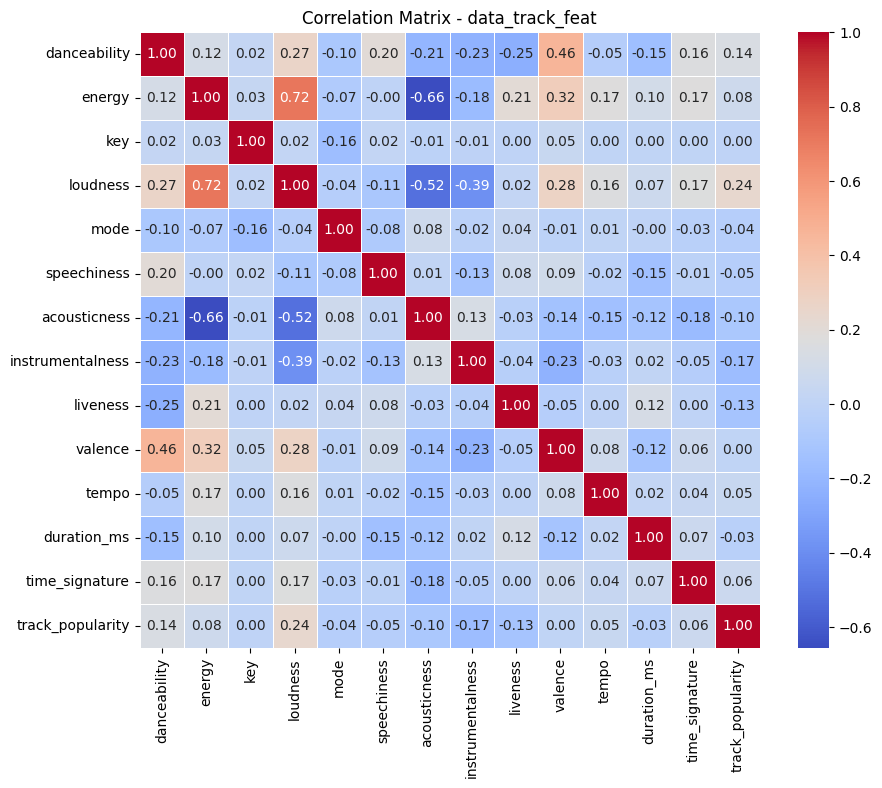

In [181]:
# Generate the correlation matrix
corr_matrix = corr_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap with seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Set the title of the plot
plt.title('Correlation Matrix - data_track_feat')

# Show the plot
plt.show()

We observe a noteworthy positive correlation between `loudness` and `track_popularity` with the highest correlation score of 0.24. Additionally, `energy` and `tempo` exhibit positive correlation scores of 0.05 and 0.06, respectively. It is evident that `valence` shows a strong correlation with `danceability` (0.46), `energy` (0.32), and `loudness` (0.28), though not directly correlating with `track_popularity`. Nonetheless, we can infer that these features play a role in influencing the popularity of a track, suggesting that tracks with higher values in these features might garner more interest.

## Data Pre processing

### Data transforming

We will merge those table into one and concatenate the genre into 1 object

In [182]:
# Merge all tables into one
searchs_table = (
    track
    .join(album, "album_id")
    .join(artist, "artist_id")
    .join(track_feat, "track_id")
    .join(genre, "artist_id")
)

We need to specify the alias for searchs table for more readable

In [183]:
searchs_table = (
    searchs_table.withColumn("track_release_year", substring("release_date", 1, 4))
    .groupBy(
        "track_id", "track_name", "track_url", "track_popularity", "track_preview",
        "artist_name", "artist_popularity", "artist_image", "track_release_year",
        "album_name", "danceability", "energy", "key", "loudness", "mode",
        "speechiness", "acousticness", "instrumentalness", "liveness", "valence",
        "tempo", "duration_ms", "time_signature"
    )
    # .agg(collect_list('genre')).alias('genre_list')
    .agg(concat_ws(',', collect_list(col('genre'))).alias('genres'))
    .orderBy("track_popularity")
)

In [184]:
# Check duplicate in searchs table
duplicate_rows = searchs_table.groupBy(searchs_table.columns).count().filter("count > 1")
duplicate_rows.show(truncate=False)

+--------+----------+---------+----------------+-------------+-----------+-----------------+------------+------------------+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+------+-----+
|track_id|track_name|track_url|track_popularity|track_preview|artist_name|artist_popularity|artist_image|track_release_year|album_name|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|genres|count|
+--------+----------+---------+----------------+-------------+-----------+-----------------+------------+------------------+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+------+-----+
+--------+----------+---------+----------------+-------------+-----------+-----------------+------------+------------------+----------+------------+------+---+----

In [185]:
searchs_table.count()

158232

In [186]:
searchs_table.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_url: string (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- track_preview: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_popularity: integer (nullable = true)
 |-- artist_image: string (nullable = true)
 |-- track_release_year: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: integer (nullable = true)
 |-- genres: st

In [187]:
searchs_table.show(5)

+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+-----------------+--------------------+------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+--------------------+
|            track_id|          track_name|           track_url|track_popularity|       track_preview|         artist_name|artist_popularity|        artist_image|track_release_year|          album_name|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|              genres|
+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+-----------------+--------------------+------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+------

Then in model, we only need track's attribute in numeric, so we would select only them in searchs_table

In [188]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import split, col
from pyspark.sql import SparkSession

def create_features_matrixs(song_library):
    # Specify the numerical columns for the features matrix
    num_cols = ['track_popularity', 'artist_popularity', 'energy', 'danceability', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
                'time_signature', 'track_release_year']

    # Select the numerical features from the song_library DataFrame
    num_features = song_library.select(num_cols)


    # Specify the HDFS URI for the Parquet file
    hdfs_uri = "hdfs://namenode:8020/model/feature_matrix.parquet"

    print('Start writing feature_matrix.parquet')
    num_features.write.parquet(hdfs_uri, mode='overwrite')
    print(f'Successfully wrote {num_features.count()} rows into feature_matrix.parquet')

    return num_features

In [189]:
num_feat = create_features_matrixs(searchs_table)

Start writing feature_matrix.parquet


23/12/19 09:06:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


Successfully wrote 158232 rows into feature_matrix.parquet


## Model

Firstly, we need to create a class to connect with dremio server named `DremioClient`

In [190]:
import pyarrow
from pyarrow import flight
import pandas as pd
import os

class DremioClient:
    def __init__(self, host, port, uid, pwd) -> None:
        self._host = host
        self._port = port
        self._uid = uid
        self._pwd = pwd

    def connect(self):
        self._client = flight.FlightClient(f"grpc://{self._host}:{self._port}")

    def authenticate(self):
        bearer_token = self._client.authenticate_basic_token(
            self._uid, self._pwd)
        options = flight.FlightCallOptions(headers=[bearer_token])
        return options

    def query(self, sql, options):
        info = self._client.get_flight_info(
            flight.FlightDescriptor.for_command(sql), options=options)
        reader = self._client.do_get(info.endpoints[0].ticket, options=options)
        df = reader.read_all().to_pandas()
        return df

Then Connect with Dremio Server

In [191]:
host = os.getenv("DREMIO_HOST")
port = os.getenv("DREMIO_PORT")
uid = os.getenv("DREMIO_USER")
pwd = os.getenv("DREMIO_PASSWORD")
client = DremioClient(host, port, uid, pwd)
client.connect()
options = client.authenticate()

We use KNN to calculate the similarity of track and return top 5 track mostly same. Training KNN model 

In [192]:
class SongRecommendationSystem:
    def __init__(self, client, options):
        self.client = client
        self.options = options
        self.knn_model = NearestNeighbors(metric='cosine')

    def fit(self, table_name):   
        matrix_table = self._get_table(table_name).values
        self.knn_model.fit(matrix_table)
        
    def _get_table(self, table_name):
        sql = f"select * from {table_name}"
        return self.client.query(sql, self.options)
        
    def recommend_songs(self, track_name: str, table_name='home.searchs', num_recommendations=5):
        song_library = self._get_table(table_name).reset_index(drop=True)
        
        if track_name not in song_library['track_name'].values:
            print(f'Track "{track_name}" not found in the dataset.')
            return None
            
        features_matrix = self._get_table('home.model')
        track_index = song_library.index[song_library['track_name'] == track_name].tolist()[0]
        _, indices = self.knn_model.kneighbors([features_matrix.iloc[track_index]], n_neighbors=num_recommendations + 1)
        return song_library.loc[indices[0][1:], :]

Now we will create recommendation model using KNN and fit with our data in `searchs` table in dremio

In [193]:
rec_model = SongRecommendationSystem(client, options)
rec_model.fit('home.model')

In [210]:
rec_model.recommend_songs('Something Just Like This', 'home.searchs')

,track_id,track_name,track_url,track_popularity,track_preview,artist_name,artist_popularity,artist_image,track_release_year,album_name,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genres
156947,6GnhWMhgJb7uyiiPEiEkDA,Weekend (feat. Miguel),https://open.spotify.com/track/6GnhWMhgJb7uyii...,80,https://p.scdn.co/mp3-preview/b2ba953f5ad2e0a2...,Mac Miller,80,https://i.scdn.co/image/ab6761610000e5ebed3b89...,2015,GO:OD AM,...,1,0.1780,0.47000,0.000000,0.147,0.190,120.058,208080,4,"pittsburgh rap,hip hop,rap,pop rap"
156415,3xby7fOyqmeON8jsnom0AT,Nightcrawler (feat. Swae Lee & Chief Keef),https://open.spotify.com/track/3xby7fOyqmeON8j...,78,https://p.scdn.co/mp3-preview/23540b3a777ceb28...,Travis Scott,90,https://i.scdn.co/image/ab6761610000e5eb19c279...,2015,Rodeo,...,0,0.0323,0.00134,0.000000,0.132,0.180,124.045,321560,4,"slap house,hip hop,rap,slap house,hip hop,rap"
120572,17hUeO3yozyGyXFzpEIX6D,Estrella,https://open.spotify.com/track/17hUeO3yozyGyXF...,44,https://p.scdn.co/mp3-preview/4ba5c04518857cb3...,Zion & Lennox,74,https://i.scdn.co/image/ab6761610000e5ebfa8445...,2021,El Sistema,...,0,0.0640,0.02930,0.000000,0.136,0.750,89.993,214626,4,"urbano latino,reggaeton,urbano latino,reggaeto..."
120504,6CrnvqCxBKVWahSiQwOesM,Hands,https://open.spotify.com/track/6CrnvqCxBKVWahS...,58,https://p.scdn.co/mp3-preview/3aedb0e37ba1057c...,Mac Miller,80,https://i.scdn.co/image/ab6761610000e5ebed3b89...,2020,Circles,...,1,0.1710,0.04590,0.000000,0.159,0.542,74.962,199981,4,"pittsburgh rap,hip hop,rap,pop rap"
145718,5Bw9bAHGaykCFLP0VyqNbJ,2 Bad,https://open.spotify.com/track/5Bw9bAHGaykCFLP...,50,https://p.scdn.co/mp3-preview/f3a9985de8a264b8...,Michael Jackson,80,https://i.scdn.co/image/ab6761610000e5eb0e08ea...,1995,"HIStory - PAST, PRESENT AND FUTURE - BOOK I",...,1,0.2490,0.06980,0.000009,0.401,0.520,103.962,289333,4,"r&b,soul"
